# Downloading and loading data

In [7]:
import os
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load a DataFrame with a specific version of a CSV
adsSales = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "thorgodofthunder/tvradionewspaperadvertising/versions/1",
    "Advertising.csv",
)

# Dataset source: https://www.kaggle.com/datasets/thorgodofthunder/tvradionewspaperadvertising
# Dataset Owner: Thor God of Thunder (Kaggle)

# Looking at Data Structure

In [8]:
adsSales.head() # First five rows
adsSales.info() # Type of attributes
adsSales.describe() # Data statistics for numeric attributes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


array([[<Axes: title={'center': 'TV'}>,
        <Axes: title={'center': 'Radio'}>],
       [<Axes: title={'center': 'Newspaper'}>,
        <Axes: title={'center': 'Sales'}>]], dtype=object)

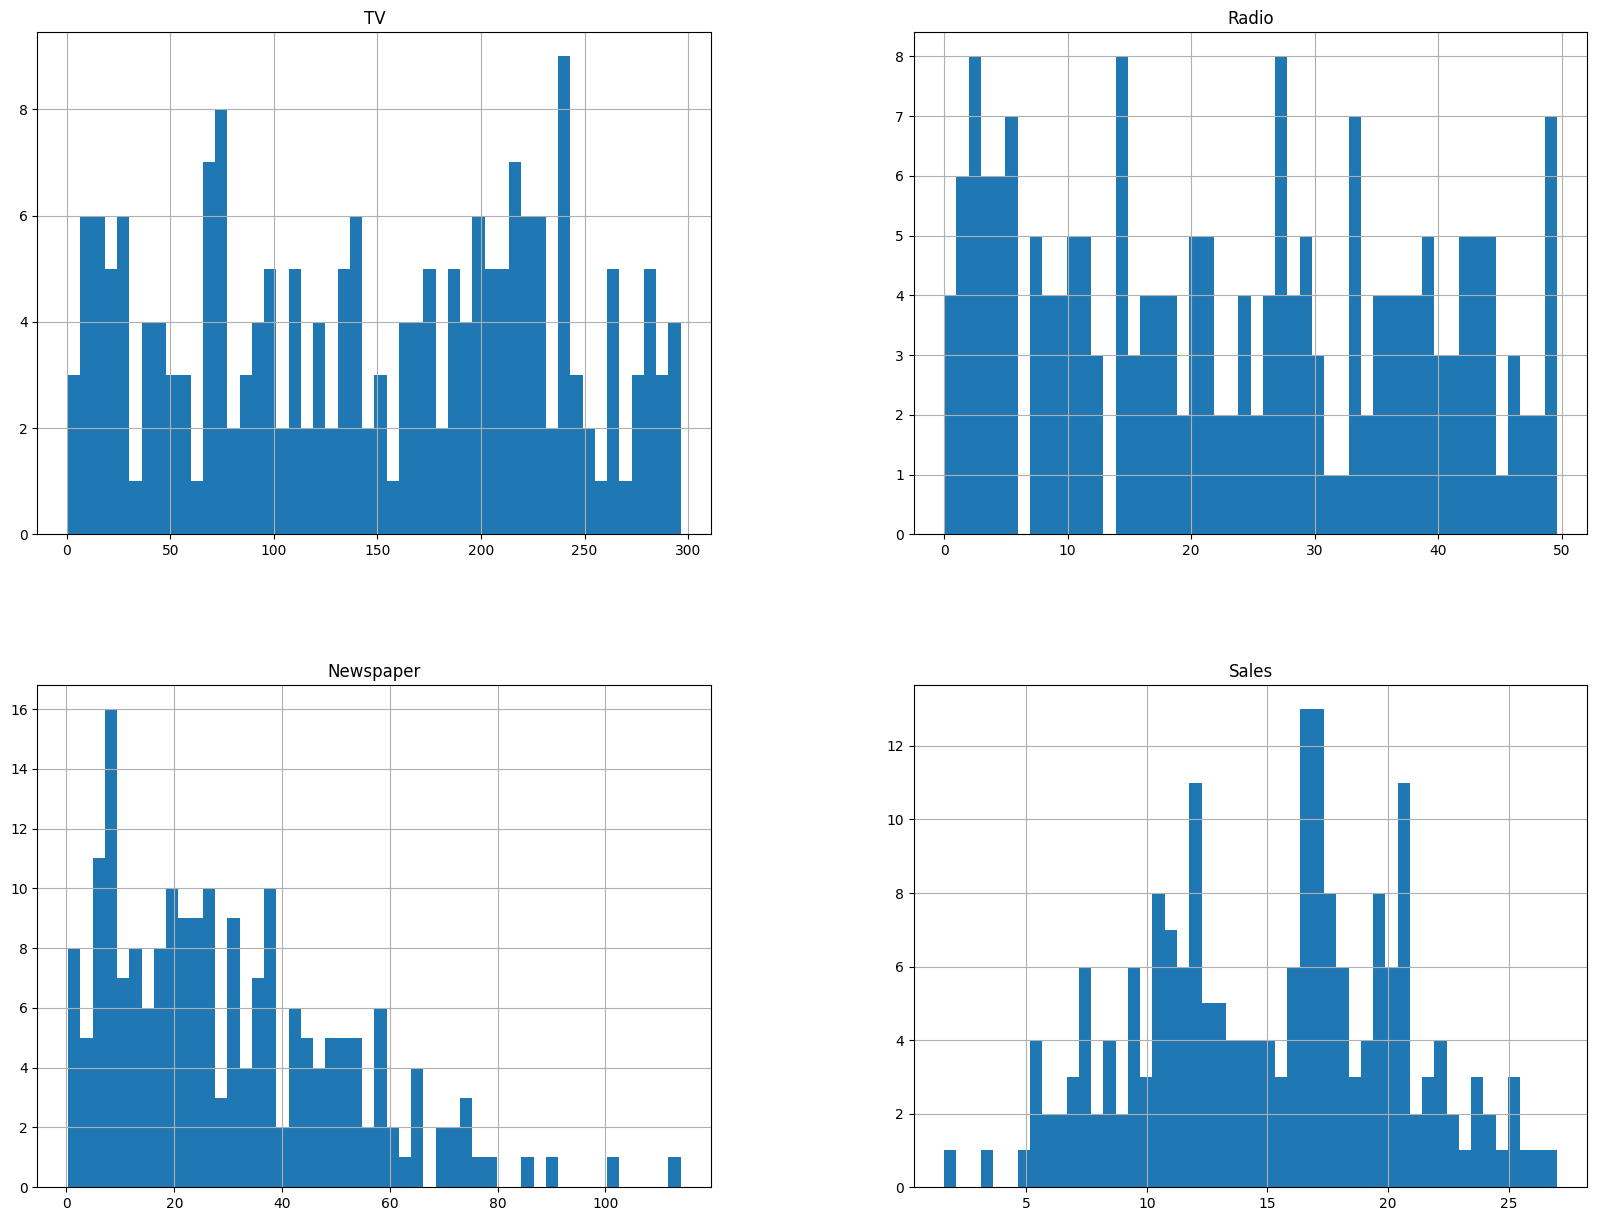

array([[<Axes: title={'center': 'TV'}>,
        <Axes: title={'center': 'Radio'}>],
       [<Axes: title={'center': 'Newspaper'}>,
        <Axes: title={'center': 'Sales'}>]], dtype=object)

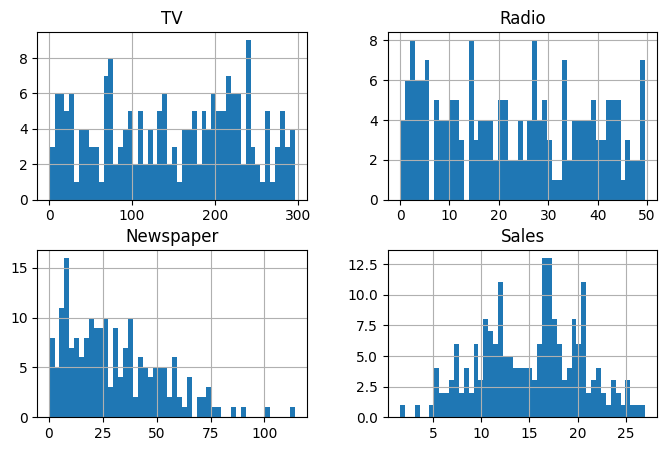

In [ ]:
# Counts levels for categorical attributes (If applicable)
# Histogram of numeric attributes

%matplotlib inline
import matplotlib.pyplot as plt
adsSales.hist(bins=50, figsize=(8,5))

# Creating Test Set

<Axes: >

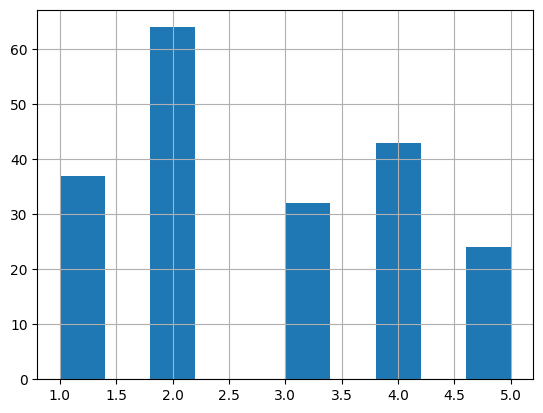

In [12]:
# Assume underlying strata for the TV attribute

import numpy as np

# Creating TV categories
adsSales["TV_cat"] = pd.cut(adsSales["TV"],
                                   bins=[0., 50., 150., 200., 250., np.inf],
                                   labels=[1, 2, 3, 4, 5])
adsSales["TV_cat"].hist()


In [13]:
# Stratified sampling

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(adsSales, adsSales["TV_cat"]):
    strat_train_set = adsSales.loc[train_index]
    strat_test_set = adsSales.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("TV_cat", axis=1, inplace=True)

# Discovering and Visualizing the Data

In [14]:
# Copying the training set
adsSales = strat_train_set.copy()

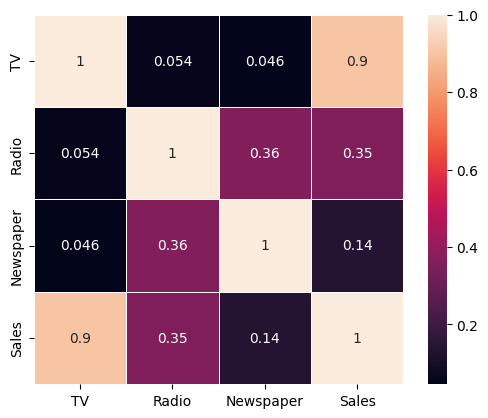

In [ ]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("colorblind")

# Looking for correlation
corr_matrix = adsSales.corr()

# Visualizing correlation 
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, square=True)
plt.savefig("eda.pdf", format="pdf", bbox_inches="tight", dpi=300) # Saving the plot as .pdf
plt.show()

# Note: One could decide to focus only on promising attributes (TV, Radio)
#       for now we keep all three since they are not so many

In [ ]:
# Attribute transformation

adsSales["logRadio"] = np.log(adsSales["Radio"])
adsSales["logNewspaper"] = np.log(adsSales["Newspaper"])

# Correlation matrix
corr_matrix = adsSales.corr()
corr_matrix["Sales"].sort_values(ascending=False)

## Note: Log transformation does not improve correlation

# Preparing Data for ML Algorithms

In [ ]:
# Note: 
#       1.- This data is clean without missing data, so there is no need for imputation.
#       2.- Further transformations besides the log-transform could be tested but we keep it simple.
#       3.- Since there are no categorical attributes, there is no need for OneHotEncoding

# Fetching the training dataset again
adsSales = strat_train_set.drop("Sales", axis=1)
adsSales_labels = strat_train_set["Sales"].copy()

# Standardizing numeric attributes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Pipeline for numerical attributes, using a pipeline (just as an example)
num_pipeline = Pipeline([
    ('attribs_scaler', StandardScaler()),
])

## Full pipeline
num_attribs = list(adsSales)

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
])

adsSales_prepared = full_pipeline.fit_transform(adsSales)

# Selecting and Training a Model

In [ ]:
# Training and evaluating on the test set: Linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lin_reg = LinearRegression()
lin_reg.fit(adsSales_prepared, adsSales_labels)

adsSales_predictions = lin_reg.predict(adsSales_prepared)
lin_mse = mean_squared_error(adsSales_labels, adsSales_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
# Training and evaluating on the training set: Decision tree

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(adsSales_prepared, adsSales_labels)

adsSales_predictions = tree_reg.predict(adsSales_prepared)
tree_mse = mean_squared_error(adsSales_labels, adsSales_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

## Note: Decision tree overfits the dataset

In [ ]:
# Improving model evaluation: K-fold cross-validation

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

def boxplot_scores(scores_dict):
    """
    Plots RMSE boxplots for multiple models from cross-validation scores.
    
    Parameters
    ----------
    scores_dict : dict
        Dictionary where keys are model names (str) and values are lists of RMSE scores.
        Example:
            {
                "Random Forest": [0.42, 0.39, 0.41, ...],
                "XGBoost": [0.36, 0.35, 0.37, ...],
                "Linear Regression": [0.50, 0.48, 0.51, ...]
            }
    """

    # Convert dictionary to DataFrame in long format
    df = pd.DataFrame({
        "Model": [model for model, scores in scores_dict.items() for _ in scores],
        "RMSE": [score for scores in scores_dict.values() for score in scores]
    })
    
    # Create the plot
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Model', y='RMSE', data=df, palette='Set2', width=0.5)
    sns.swarmplot(x='Model', y='RMSE', data=df, color='black', alpha=0.6, size=4)
    
    # Formatting
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.tight_layout()
    plt.savefig("scores.pdf", format="pdf", bbox_inches='tight', dpi=300) # Saving the plot as .pdf
    plt.show()

# Decision tree
scores = cross_val_score(tree_reg, adsSales_prepared, adsSales_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

# Linear regression
scores = cross_val_score(lin_reg, adsSales_prepared, adsSales_labels,
                        scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

# Random forest
forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, adsSales_prepared, adsSales_labels,
                        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

# Support vector machine
svm_reg = SVR()
scores = cross_val_score(svm_reg, adsSales_prepared, adsSales_labels,
                        scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)

boxplot_scores({"Decision Tree":tree_rmse_scores, "Linear Regression":lin_rmse_scores,
                "Random Forest":forest_rmse_scores, "SVM":svm_rmse_scores})

# Fine-Tuning the Best Model (Random Forest)

In [ ]:
# Hyper-parameters tuning using grid search

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 50], 'max_features': [6, 8, 10]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error', return_train_score=True)

# Fit model for all combinations of parameters
grid_search.fit(adsSales_prepared, adsSales_labels)

In [ ]:
# Grid search outcome

grid_search.best_params_    # Best model parameters
grid_search.best_estimator_ # Best estimator
cvres = grid_search.cv_results_

# Evaluating Model on Test Set

In [ ]:
# Picking best model from grid search

final_model = grid_search.best_estimator_

In [ ]:
# Defining test dataset

X_test = strat_test_set.drop("Sales", axis=1)
y_test = strat_test_set["Sales"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [ ]:
# Running predictions on test set

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

In [ ]:
# Finding generalization error with 95% confidence interval

from scipy import stats

confidence = 0.95
squarred_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squarred_errors)-1,
                        loc=squarred_errors.mean(),
                        scale=stats.sem(squarred_errors)))

# Saving the Model for Possible Launch and Monitoring

In [ ]:
# Saving the model as joblib file

def save_model(model, name="model", model_path="./"):
    """
    Save the model with a given name to a specific location.
    
    Parameters
    ----------
    model : 
        The model trained.
    name:
        The file name with which to save the model
    model_path:
        The path in which the model is saved
        Example:
            "./models/"
            
    """
    os.makedirs(model_path, exist_ok=True)
    model_name = name + ".pkl"
    pkl_path = os.path.join(model_path, model_name)
    joblib.dump(model, pkl_path)

MODEL_PATH = os.path.join("models", "adsSales")
save_model(final_model, name="Random_forest_V1.1", model_path=MODEL_PATH)